### Set up

In [1]:
import os

import dotenv
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    HnswAlgorithmConfiguration,
    HnswParameters,
    SearchField,
    SearchFieldDataType,
    SearchIndex,
    SimpleField,
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchProfile,
)
from azure.search.documents.models import VectorizedQuery



In [2]:
#dotenv.load_dotenv()
from dotenv import load_dotenv
load_dotenv('.env')

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient

AZURE_SEARCH_SERVICE = os.getenv("AZURE_SEARCH_SERVICE")
AZURE_SEARCH_ENDPOINT = f"https://{AZURE_SEARCH_SERVICE}.search.windows.net"
AZURE_SEARCH_IMAGES_INDEX = os.getenv("AZURE_SEARCH_IMAGES_INDEX")
# AZURE_SEARCH_IMAGES_INDEX = "vector-images-5350"
AZURE_SEARCH_API_KEY = os.environ["AZURE_SEARCH_API_KEY"]

service_endpoint = AZURE_SEARCH_ENDPOINT
key = AZURE_SEARCH_API_KEY
index_name = AZURE_SEARCH_IMAGES_INDEX



search_client = SearchClient(service_endpoint, index_name, AzureKeyCredential(key))
azure_credential = DefaultAzureCredential(exclude_shared_token_cache_credential=True)

print(f"Azure Cognitive Search endpoint: {service_endpoint}")
print(f"Azure Cognitive Search index: {index_name}")


Azure Cognitive Search endpoint: https://cb-ai-search.search.windows.net
Azure Cognitive Search index: vector-images-5350


### Create search index for images

In [3]:
index = SearchIndex(
    name=AZURE_SEARCH_IMAGES_INDEX, 
    fields=[
        SimpleField(name="id", type=SearchFieldDataType.String, key=True),
        SimpleField(name="filename", type=SearchFieldDataType.String),
        # SearchField(name="image_vector"),
        SearchField(name="embedding", 
                    type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
                    searchable=True, 
                    vector_search_dimensions=1024,
                    vector_search_profile_name="embedding_profile")
    ],
    vector_search=VectorSearch(
        algorithms=[HnswAlgorithmConfiguration(
                            name="hnsw_config",
                            kind=VectorSearchAlgorithmKind.HNSW,
                            parameters=HnswParameters(metric="cosine"),
                        )],
        profiles=[VectorSearchProfile(name="embedding_profile", algorithm_configuration_name="hnsw_config")]
    )
)


index_client = SearchIndexClient(AZURE_SEARCH_ENDPOINT, AzureKeyCredential(key))
#index_client.create_index(index)
index_client.create_or_update_index
# print(index_client.get_index(AZURE_SEARCH_IMAGES_INDEX))
print(AZURE_SEARCH_IMAGES_INDEX)


vector-images-5350


### Configure Azure Computer Vision multi-modal embeddings API 

In [4]:
import mimetypes
import os

import requests
from PIL import Image

#see
#https://github.com/Azure-Samples/cognitive-services-quickstart-code/blob/master/python/ComputerVision/REST/python-analyze.md

token_provider = get_bearer_token_provider(azure_credential, "https://cognitiveservices.azure.com/.default")
AZURE_COMPUTERVISION_SERVICE = os.getenv("AZURE_COMPUTERVISION_SERVICE")


# Add your Computer Vision key and endpoint to your environment variables.
#if 'AZURE_COMPUTER_VISION_KEY' in os.environ:
#    subscription_key = os.environ['AZURE_COMPUTER_VISION_KEY']
#else:
#    print("\nSet the AZURE_COMPUTER_VISION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
#    sys.exit()

subscription_key = os.getenv("AZURE_COMPUTER_VISION_KEY")


AZURE_COMPUTER_VISION_URL = f"https://{AZURE_COMPUTERVISION_SERVICE}.cognitiveservices.azure.com/computervision/retrieval"

def get_model_params():
    return {"api-version": "2023-02-01-preview", "modelVersion": "latest"}

def get_auth_headers():
    return {'Ocp-Apim-Subscription-Key': subscription_key}

def get_image_embedding(image_file):
    mimetype = mimetypes.guess_type(image_file)[0]
    url = f"{AZURE_COMPUTER_VISION_URL}:vectorizeImage"
    headers = get_auth_headers()
    headers["Content-Type"] = mimetype
    # add error checking
    response = requests.post(url, headers=headers, params=get_model_params(), data=open(image_file, "rb"))
    if response.status_code != 200:
        print(image_file, response.status_code, response.json())
    return response.json()["vector"]

def get_text_embedding(text):
    url = f"{AZURE_COMPUTER_VISION_URL}:vectorizeText"
    return requests.post(url, headers=get_auth_headers(), params=get_model_params(), json={"text": text}).json()["vector"]

In [31]:
#https://www.youtube.com/watch?v=Y0dLgtF4IHM
#https://colab.research.google.com/drive/19ulJqMQqk4PfcTx1v3C3cxjvzokrKgZS?usp=sharing#scrollTo=PZtR0-5BfzG7
#https://github.com/kipr/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

# Image recognition with Python, OpenCV, OpenAI CLIP model and Azure Search AI & Azure Vision  `embeddings`

This repository contains the working code for the example in the [blog post](https://aiven.io/developer/find-faces-with-pgvector)

The below is the overall flow:

![Overall flow](https://github.com/Aiven-Labs/pgvector-image-recognition/blob/main/entire_flow.jpg?raw=1)

In [5]:
# Step 0: Import Libraries
!pip install opencv-python imgbeddings psycopg2-binary

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 29.2 MB/s eta 0:00:0000:0100:01
Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
  Created wheel for imgbeddings: filename=imgbeddings-0.1.0-py3-none-any.whl size=9320 sha256=2b3ed474df683365f29d4bfb8b33271af3092f5bab3b031f96e9dffddfc11fde
  Stored in directory: /Users/jportilla/Library/Caches/pip/wheels/44/25/45/faf940ae980b321ddb51becf6a38c32800af42853801c17cd0
Successfully built imgbeddings


In [8]:
# importing the cv2 library
import cv2

# loading the haar case algorithm file into alg variable
alg = "haarcascade_frontalface_default.xml"
# passing the algorithm to OpenCV
haar_cascade = cv2.CascadeClassifier(alg)
# loading the image path into file_name variable - replace <INSERT YOUR IMAGE NAME HERE> with the path to your image
file_name = "imgs/MI-8.jp2"
# reading the image
img = cv2.imread(file_name, 0)
# creating a black and white version of the image
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# detecting the faces
faces = haar_cascade.detectMultiScale(
    gray_img, scaleFactor=1.05, minNeighbors=2, minSize=(100, 100)
)

i = 0
# for each face detected
for x, y, w, h in faces:
    # crop the image to select only the face
    cropped_image = img[y : y + h, x : x + w]
    # loading the target image path into target_file_name variable  - replace <INSERT YOUR TARGET IMAGE NAME HERE> with the path to your target image
    target_file_name = 'stored-faces/' + str(i) + '.jpg'
    cv2.imwrite(
        target_file_name,
        cropped_image,
    )
    i = i + 1;

[ WARN:0@309.733] global grfmt_jpeg2000_openjpeg.cpp:607 readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed


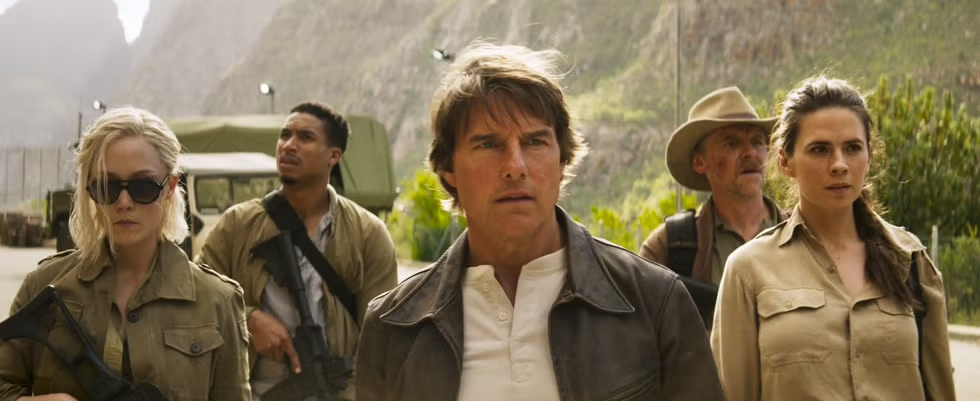

In [33]:
query_image = "./imgs/MI8.png"
Image.open(query_image)

### Add image vectors to search index

In [10]:


import os

for image_file in os.listdir("./stored-faces"):
    # Ensure the image file is not empty
    if image_file:
        print(image_file)
        # Fix access problem to get_image_embedding token
        image_embedding = get_image_embedding(f"./stored-faces/{image_file}")
        # print(len(image_embedding))
        doc_id = image_file.split(".")[0]
        # print(doc_id)
        search_client.upload_documents(documents=[{
            "id": doc_id,  # Ensure this field is not empty
            "filename": image_file,
            "embedding": image_embedding
        }])

2.jpg
1.jpg
0.jpg


### Query using an image

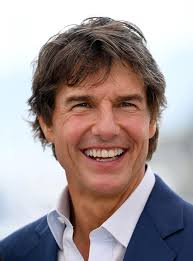

In [11]:
query_image = "./imgs/tomc.jpeg"
Image.open(query_image)

In [12]:
query_vector = get_image_embedding(query_image)
r = search_client.search(search_text=None, vector_queries=[
    VectorizedQuery(vector=query_vector, k_nearest_neighbors=3, fields="embedding")])
all = [doc["filename"] for doc in r]
for filename in all:
    print(filename)

0.jpg
1.jpg
2.jpg


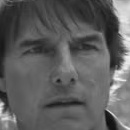

In [13]:
Image.open("./stored-faces/" + all[0])

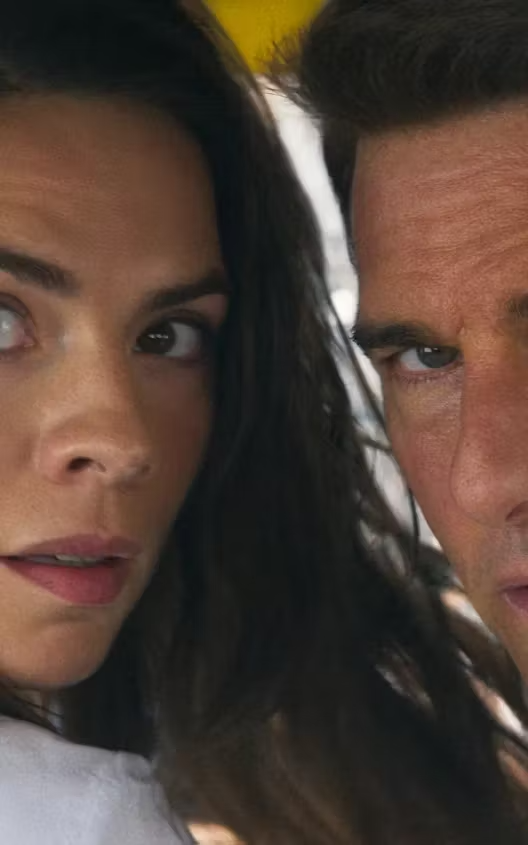

In [22]:
query_image = "./imgs/hayley.png"
Image.open(query_image)

In [23]:
query_vector = get_image_embedding(query_image)
r = search_client.search(search_text=None, vector_queries=[
    VectorizedQuery(vector=query_vector, k_nearest_neighbors=3, fields="embedding")])
all = [doc["filename"] for doc in r]
for filename in all:
    print(filename)

0.jpg
2.jpg
1.jpg


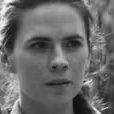

In [26]:
Image.open("stored-faces/" + all[1])

In [27]:
query_vector = get_text_embedding("gafas oscuras")
r = search_client.search(None, vector_queries=[
    VectorizedQuery(vector=query_vector, k_nearest_neighbors=3, fields="embedding")])
all = [doc["filename"] for doc in r]
for filename in all:
    print(filename)

1.jpg
doubletealight2_aboveside.jpg
doubletealight1_aboveside.jpg


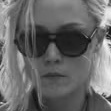

In [28]:
Image.open("stored-faces/" + all[0])

In [29]:
query_vector = get_text_embedding("blond")
r = search_client.search(None, vector_queries=[
    VectorizedQuery(vector=query_vector, k_nearest_neighbors=3, fields="embedding")])
all = [doc["filename"] for doc in r]
for filename in all:
    print(filename)

1.jpg
amulet8_fullshot.jpg
amulet9_fullshot.jpg


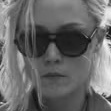

In [21]:
Image.open("stored-faces/" + all[0])